In [17]:
%run init.ipynb

# PCA:
# - overall (for all players without ranking estimates on other positions). 
#   Is exactly representative for the set of players on their preferred positions.
# - goalkeepers (closer look - since goalkeepers constitute only a small % of the dataset; 
#   to appreciate the goalkeeping measures variability).
# - ??? outfilders (to appreciate the ranking estimates on other positions). -> produces unreadable FP.

## Principal Component Analysis
If other is not mentioned explicitly, we perform **PCA** for the ***1st*** and the ***2nd*** **principal components**.

- ### PCA framework.
A set of functions to be used for the *Principal Component Analysis*.

In [18]:
def pca(dataframe):
    # Given a dataframe scales (normalizes) it 
    # and computes the eigenvalues and eigenvectors 
    # of the corresponding covariance matrix.
    
    normDf = ((dataframe - dataframe.mean()) / \
              dataframe.std())

    covMatrix = normDf.cov()
    initEigvals, initEigvecs = np.linalg.eigh(covMatrix)

    sortedPairs = sorted(zip(initEigvals, initEigvecs.T), \
                    key = lambda item: -item[0])
    
    eigvals = [item[0] for item in sortedPairs]
    eigvecs = [item[1] for item in sortedPairs]
    
    return (normDf, eigvals, eigvecs)



def pcaProjection(normDf, eigvecs, pcN1 = 0, pcN2 = 1):
    # For two given principal components, calculates the positions
    # of data points in the factorial plane.
    
    xs = normDf @ eigvecs[pcN1]
    ys = normDf @ eigvecs[pcN2]
    
    return (xs, ys)



def pcaBiplot(points, variances, eigvecs, columns, \
              scaling=10.0, nArrows = -1, pcN1 = 0, pcN2 = 1):
    # Produces the biplot w.r.t. two given principal components (zero-based);
    # The default value nArrows = -1 means arrows for ALL the variables. 
    
    xs = points[0]
    ys = points[1]
    
    pcN1VarExplained = variances[pcN1] / sum(variances) * 100
    pcN2VarExplained = variances[pcN2] / sum(variances) * 100
    
    varExplained = \
        pcN1VarExplained + pcN2VarExplained
    
    plt.figure(figsize=(20,20))
    plt.title("PCA: Factorial plane ({0:1.1f} % of variance explained)"\
              .format(varExplained), fontsize = 16, fontweight='bold')
    
    plt.xlabel("PC {0} ({1:1.1f} %)"\
               .format(pcN1 + 1, pcN1VarExplained), fontsize = 14, fontweight='bold')
    plt.ylabel("PC {0} ({1:1.1f} %)"\
               .format(pcN2 + 1, pcN2VarExplained), fontsize = 14, fontweight='bold')

    plt.scatter(xs, ys, s = 25);
    
    arrows = []
    for x, y, col in zip(eigvecs[pcN1], eigvecs[pcN2], columns):
        arrows.append((x, y, col))
    
    arrows = sorted(arrows, key = \
                lambda item: -(item[0]**2 + item[1]**2))
    
    if nArrows == -1:
        nArrows = len(variances)
        
    for i in range(nArrows):
        arr = arrows[i]
        sclX, sclY = scaling*arr[0], scaling*arr[1]
        col = arr[2]
        
        ax = plt.gca()
        arr = plt.arrow(0,0, sclX, sclY, edgecolor='r', \
                        width=0.01, facecolor = 'r')

        annotX = sclX + 0.3*np.sign(sclX)
        annotY = sclY + 0.3*np.sign(sclY)
        ax.annotate(col, xy=(sclX, sclY), xytext=(annotX, annotY), \
                   fontsize = 16)

        ax.add_patch(arr)
    
    plt.show()

    
    
def pcaScreeplot(variances, pcN1 = 0, pcN2 = 1):
    # Given an ordered array of variances, plots the screeplot 
    # of a percentage of variance of scaled data 
    # explained by each principal component.

    totalVars = sum(variances)
    xs = [i+1 for i in range(len(variances))]
    ys = [v / totalVars * 100 for v in variances]

    plt.figure(figsize=(12,6))
    plt.title("PCA: Scree Plot", fontsize = 16, fontweight='bold')

    plt.xlabel("Principal Component", fontsize = 14, fontweight='bold')
    plt.ylabel("% of Variance Explained", fontsize = 14, fontweight='bold')

    plt.plot(xs, ys, 'bo-');
    

    
def pcaPerform(df, scaling=10):
    # Shortcut for PCA results for different datasets.
    
    normDf, variances, eigvecs = pca(df)

    pcaBiplot(pcaProjection(normDf, eigvecs), \
          variances, eigvecs, df.columns, scaling=scaling)

- ### Overall PCA.

Includes all the numerical variables EXCEPT the *ranking estimate for other positions*.

It is exactly **representative** for the set of players on their **preferred positions**.

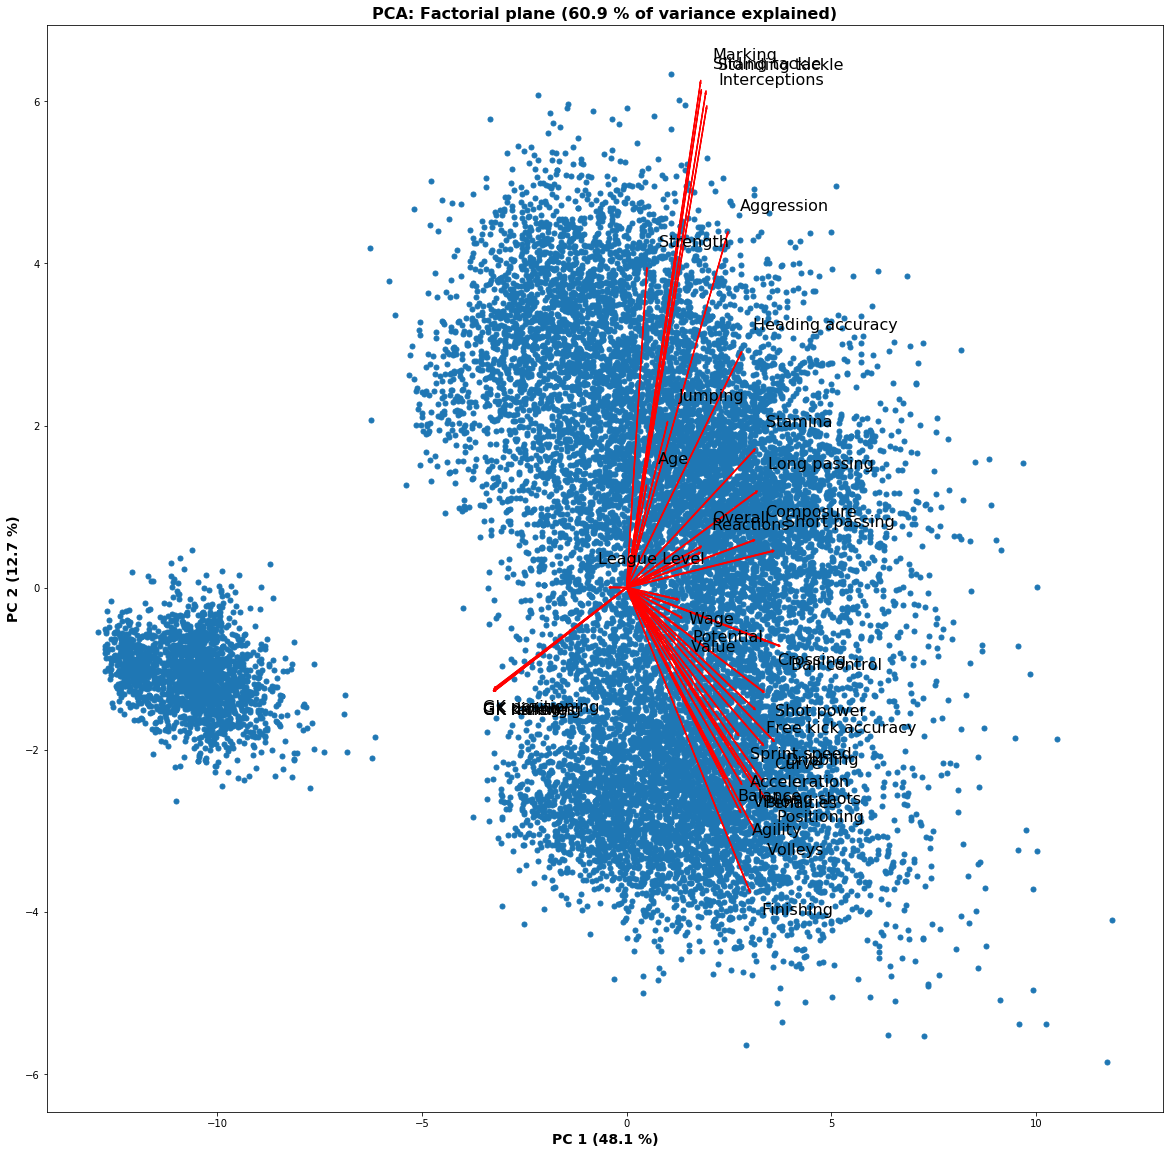

In [19]:
overallDf = df.select_dtypes(include='number')\
                .dropna(axis='columns')

pcaPerform(overallDf, scaling=17)

### Preliminary conclusions:
- The *factorial plane* represents **almost 2/3 of the total variance** in the dataset - quite large percentage.
- The **1st PC** has to do with **goalkeeper vs outfielder variability**, and hence the dataset is naturally split into **two groups**: *goalkeepers* (the cluster on the left, since it posses the *maximal values of goalkeeping attributes*) and *outfielders* (on the right). That is why the 1st PC explain so much (almost 1/2) of all variance.
- The **2nd PC** is loaded mostly on such attributes as *marking, sliding tackle, interception, aggression etc.* (crucial for **defeding players**), and *finishing, volleys, acceleration, free kick accuracy, agility etc.* (crucial for **attacking players**), and they tend to be *negatively collinear*. **Hence**, the **2nd PC** has to do with the general position on a pitch (defender, midfielder or striker).
- **Consequence**: 2/3 of the variance is carried by *the role of players* (quite naturally). 
- **goalkeeping attributes** are *collinear* - very *higly correlated*.
- The *goalkeepers cluster* deserves a **closer look**.

- ### PCA for the goalkeepers.

We consider all the **numerical variables** except the *ranking estimate for other positions* (by the assumptions of the dataset, for the goalkeepers it is set to NaN).

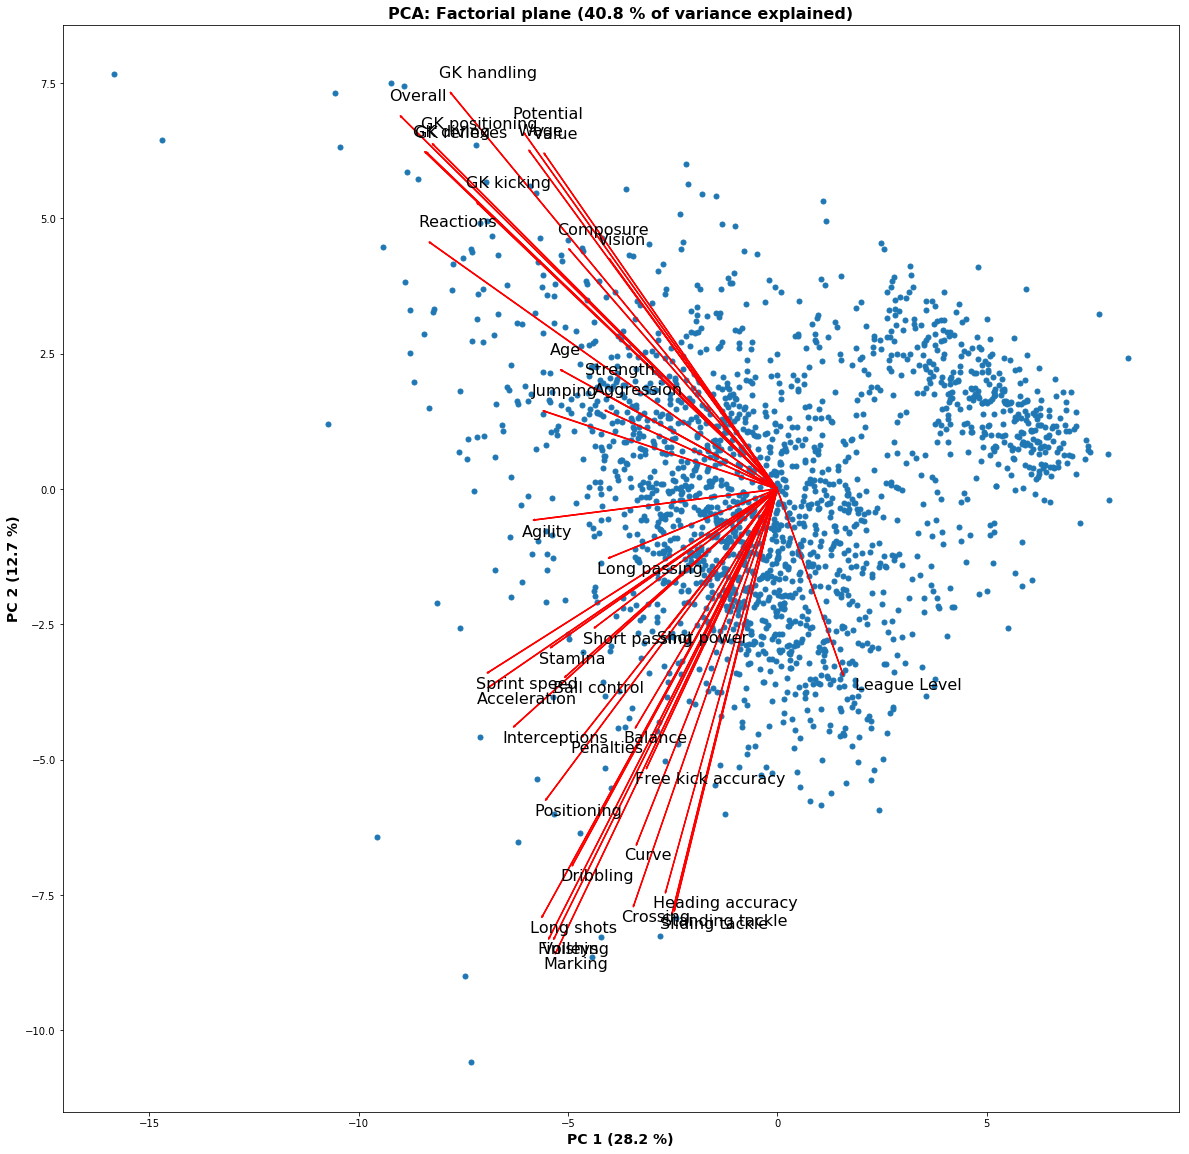

In [20]:
keepersDf = df[df["Preferred Positions"] == "GK"]\
                .select_dtypes(include='number')\
                .dropna(axis='columns')

pcaPerform(keepersDf, scaling=35)

### Preliminary conclusions:
- The *factorial plane* represents **nearly 1/2 of the total variance** in the dataset - quite large percentage.
- The **1st PC** has to do with the **general qualification of a player** (*the more* we move to the *left half-plane*, *the more skilled* is the player in general).
- The **2nd PC** is loaded mostly on *key goalkeeping attributes* (overall, GK handling, GK positioning etc.) with positive sign, and *outfield attributes* (dribbling, crossing etc.) with negative sign. Hence, the **2nd PC** has to do with **how good is a player on the goalkeeper position** (*the more* we move to the *upper half*, *the more goalkeeping skills* a player posseses). [**TODO**: formulate *clearlier*].
- the **key goalkeeping attributes** (overall, GK handling, GK positioning etc.) tend to be *collinear* (*highly correlated*).
- the **key goalkeeping attributes** are *negatively collinear* w.r.t. the **league level** (*the higher* the league *rank* (the smaller number), *the better goalkeepers* play there - quite naturally).

- ### PCA for outfielders (by/with positions).

[**Not sure**. Produces an unreadable factorial plane.]

In [21]:
# positionOFDf = df[df["Preferred Positions"] != "GK"]\
#                     .loc[:,'CAM':'ST']
        
# positionOFDf = df[df["Preferred Positions"] != "GK"]\
#                     .select_dtypes(include='number')
        
# pcaPerform(positionOFDf, scaling=40)